In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


In [2]:
# -----------------------------
# 1. DATA LOADING AND PREPARATION
# -----------------------------

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load df_trips DataFrame
# Replace 'filtered_df_2.parquet' with your actual file path if different
df_trips = pd.read_parquet('filtered_df_2.parquet')

# Display the first few rows of df_trips
print("df_trips Sample:")
print(df_trips.head())

# Load NYC Taxi Zones GeoJSON file
gdf_zones = gpd.read_file('NYC Taxi Zones.geojson')

# Display the first few rows of gdf_zones
print("\nNYC Taxi Zones GeoDataFrame Sample:")
print(gdf_zones.head())

# Ensure matching data types for merging
# Assuming 'zone_id' in df_trips corresponds to 'location_id' in gdf_zones
df_trips['PULocationID'] = df_trips['PULocationID'].astype(str)
gdf_zones['location_id'] = gdf_zones['location_id'].astype(str)

# Aggregate pickup counts per zone
pickup_aggregation = df_trips.groupby('PULocationID').size().reset_index(name='Pickup_Trips')

# Merge pickup counts with GeoDataFrame
gdf_merged = gdf_zones.merge(pickup_aggregation, left_on='location_id', right_on='PULocationID', how='left')

# Handle missing pickup counts by filling with 0
gdf_merged['Pickup_Trips'] = gdf_merged['Pickup_Trips'].fillna(0)

# Display merged GeoDataFrame
print("\nMerged GeoDataFrame Sample:")
print(gdf_merged.head())

# Calculate centroids to obtain latitude and longitude
# Check the Coordinate Reference System (CRS)
print("\nOriginal CRS of GeoDataFrame:")
print(gdf_merged.crs)

# If CRS is geographic (degrees), project to a planar CRS for accurate centroid calculation
if gdf_merged.crs.is_geographic:
    # Project to Web Mercator (EPSG:3857)
    gdf_merged = gdf_merged.to_crs(epsg=3857)
    print("\nCRS after projection to EPSG:3857:")
    print(gdf_merged.crs)

# Calculate centroids
gdf_merged['centroid'] = gdf_merged.geometry.centroid

# Extract latitude and longitude from centroids
# Since projected to EPSG:3857, convert back to EPSG:4326 for latitude and longitude
gdf_merged_centroid = gdf_merged.set_geometry('centroid').to_crs(epsg=4326)

gdf_merged['centroid_lat'] = gdf_merged_centroid.geometry.y
gdf_merged['centroid_lon'] = gdf_merged_centroid.geometry.x

# Display centroids
print("\nGeoDataFrame with Centroid Coordinates:")
print(gdf_merged[['location_id', 'Pickup_Trips', 'centroid_lat', 'centroid_lon']].head())


df_trips Sample:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  trip_duration  \
0         1  2023-11-01 00:03:03   2023-11-01 01:04:08      61.083333   
1         2  2023-11-01 00:03:50   2023-11-01 00:04:59       1.150000   
2         2  2023-11-01 00:06:30   2023-11-01 00:14:25       7.916667   
3         2  2023-11-01 00:17:18   2023-11-01 00:23:39       6.350000   
4         2  2023-11-01 00:14:49   2023-11-01 00:39:44      24.916667   

   pickup_hour pickup_day_of_week  passenger_count  trip_distance  RatecodeID  \
0            0          Wednesday              2.0          13.60         1.0   
1            0          Wednesday              1.0           0.39         1.0   
2            0          Wednesday              1.0           1.20         1.0   
3            0          Wednesday              3.0           0.60         1.0   
4            0          Wednesday              1.0           5.44         1.0   

   PULocationID  DOLocationID  payment_type  fare_amount 

In [3]:
# -----------------------------
# 2. FEATURE SCALING
# -----------------------------

# Extract the centroid coordinates for clustering
coords = gdf_merged[['centroid_lat', 'centroid_lon']]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the coordinates
coords_scaled = scaler.fit_transform(coords)

# Convert scaled coordinates back to a DataFrame
coords_scaled_df = pd.DataFrame(coords_scaled, columns=['lat_scaled', 'lon_scaled'])

# Display scaled coordinates
print("\nScaled Coordinates Sample:")
print(coords_scaled_df.head())



Scaled Coordinates Sample:
   lat_scaled  lon_scaled
0   -0.399201   -2.538009
1   -1.279877    1.045733
2    1.625719    0.877113
3   -0.024820   -0.477589
4   -2.031573   -2.689475


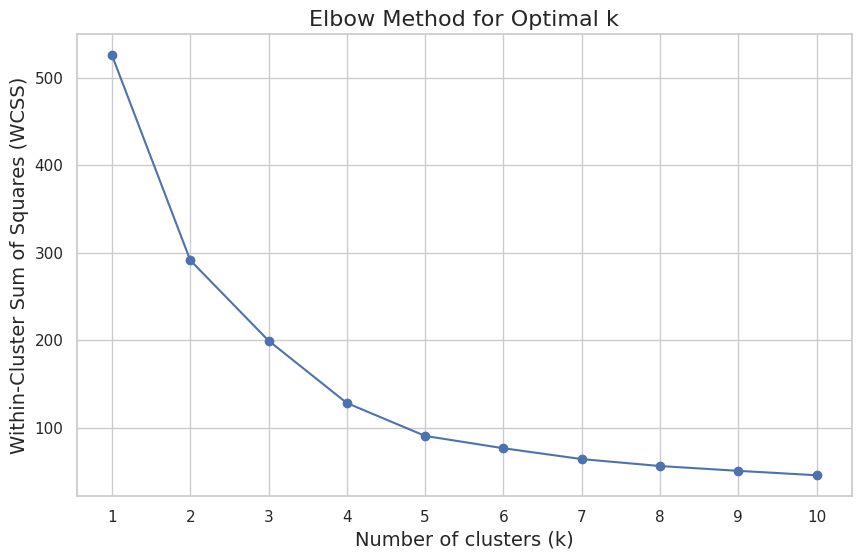

In [4]:
# -----------------------------
# 3. ELBOW METHOD TO DETERMINE OPTIMAL K
# -----------------------------

# List to hold Within-Cluster Sum of Squares (WCSS) for each k
wcss = []

# Range of k values to try
k_range = range(1, 11)

# Compute WCSS for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(coords_scaled_df)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of clusters (k)', fontsize=14)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=14)
plt.xticks(k_range)
plt.show()


In [5]:
# -----------------------------
# 4. K-MEANS CLUSTERING WITH OPTIMAL K
# -----------------------------

# Define the optimal number of clusters based on the Elbow Method
optimal_k = 5  # Replace with your determined k

# Initialize KMeans with the optimal k
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit KMeans on the scaled coordinates and predict cluster labels
gdf_merged['Cluster'] = kmeans_optimal.fit_predict(coords_scaled_df)

# Display cluster assignments
print(f"\nCluster Assignments with k={optimal_k}:")
print(gdf_merged[['location_id', 'Pickup_Trips', 'centroid_lat', 'centroid_lon', 'Cluster']].head())



Cluster Assignments with k=5:
  location_id  Pickup_Trips  centroid_lat  centroid_lon  Cluster
0           1         276.0     40.691833    -74.174000        3
1           2          35.0     40.616749    -73.831298        0
2           3          74.0     40.864474    -73.847422        2
3           4       31851.0     40.723752    -73.976968        4
4           5           0.0     40.552660    -74.188484        3


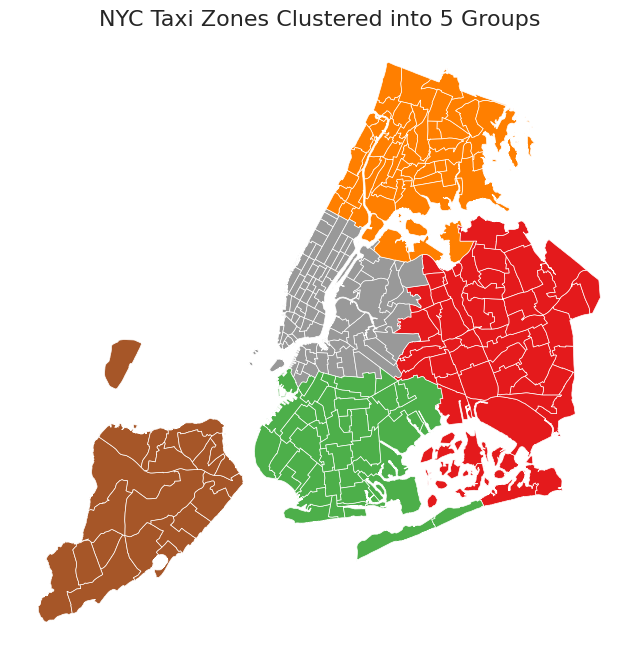

In [6]:
# -----------------------------
# 5A. VISUALIZATION OF CLUSTERS ON A CHOROPLETH MAP
# -----------------------------

# Define a color palette for clusters
palette = sns.color_palette('Set1', n_colors=optimal_k).as_hex()

# Plot the choropleth with cluster assignments
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

gdf_merged.plot(
    column='Cluster',
    cmap='Set1',
    linewidth=0.5,
    edgecolor='white',
    ax=ax
)

ax.set_title(f"NYC Taxi Zones Clustered into {optimal_k} Groups", fontsize=16)
ax.axis('off')  # Hide axis

plt.show()


In [6]:
# -----------------------------
# 4. MERGING CLUSTER INFORMATION BACK TO PICKUP DATA
# -----------------------------

# 4.1 Merge cluster labels into df_daily_zone
df_daily_cluster = df_daily_zone.merge(
    gdf_zones[['location_id', 'cluster']],
    left_on='zone_id',
    right_on='location_id',
    how='left'
)

# Drop redundant columns
df_daily_cluster.drop(['location_id'], axis=1, inplace=True)

# Display merged data
print("\nDaily Pickup Counts per Cluster:")
print(df_daily_cluster.head())

# 4.2 Aggregate pickup counts per cluster per day
df_daily_cluster_agg = df_daily_cluster.groupby(['cluster', 'pickup_date']).agg({
    'pickup_count': 'sum',
    'day_of_week': 'first',
    'month': 'first',
    'is_holiday': 'first'
}).reset_index()

# Display aggregated data
print("\nAggregated Daily Pickup Counts per Cluster:")
print(df_daily_cluster_agg.head())

: 

In [1]:
# -----------------------------
# 6. MODELING
# -----------------------------

# 6.1 Define features and target
features = ['cluster', 'day_of_week', 'month', 'is_holiday']
target = 'pickup_count'

X = df_daily_cluster_agg[features]
y = df_daily_cluster_agg[target]

# 6.2 Split data into training and testing sets
# Use the latest 20% of data as the test set to mimic real-world prediction
split_date = df_daily_cluster_agg['pickup_date'].quantile(0.8)
X_train = X[df_daily_cluster_agg['pickup_date'] <= split_date]
y_train = y[df_daily_cluster_agg['pickup_date'] <= split_date]
X_test = X[df_daily_cluster_agg['pickup_date'] > split_date]
y_test = y[df_daily_cluster_agg['pickup_date'] > split_date]

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# 6.3 Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 6.4 Train the model
rf.fit(X_train, y_train)

# 6.5 Predict on the test set
y_pred = rf.predict(X_test)

NameError: name 'df_daily_cluster_agg' is not defined

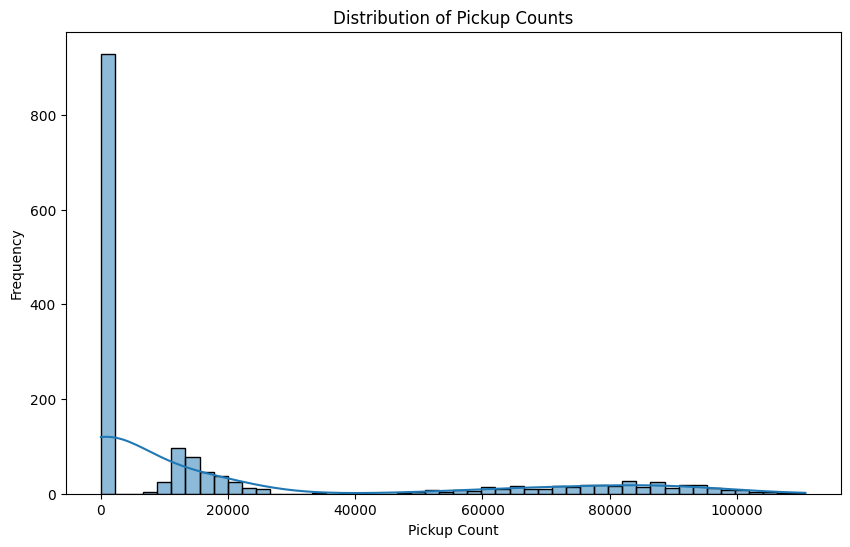

In [14]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df_daily['pickup_count'], bins=50, kde=True)
plt.title('Distribution of Pickup Counts')
plt.xlabel('Pickup Count')
plt.ylabel('Frequency')
plt.show()


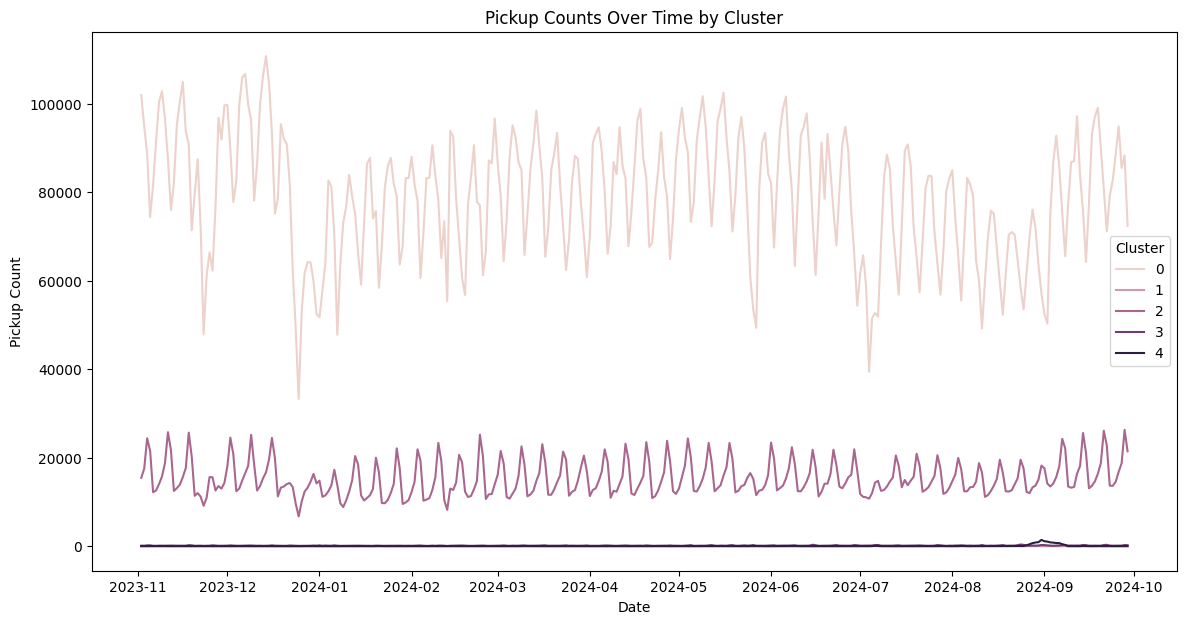

In [19]:
plt.figure(figsize=(14,7))
sns.lineplot(data=df_daily, x='pickup_date', y='pickup_count', hue='cluster')
plt.title('Pickup Counts Over Time by Cluster')
plt.xlabel('Date')
plt.ylabel('Pickup Count')
plt.legend(title='Cluster')
plt.show()


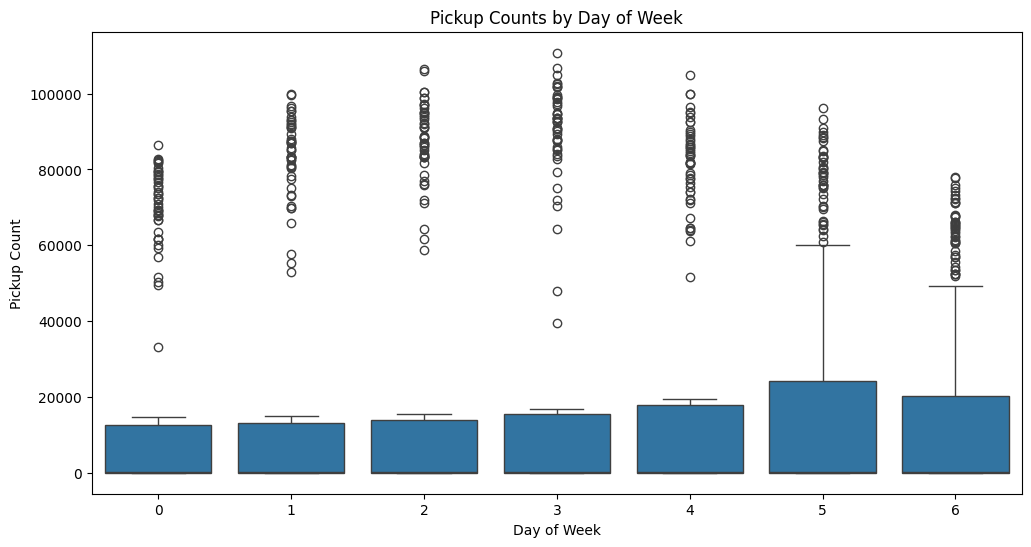

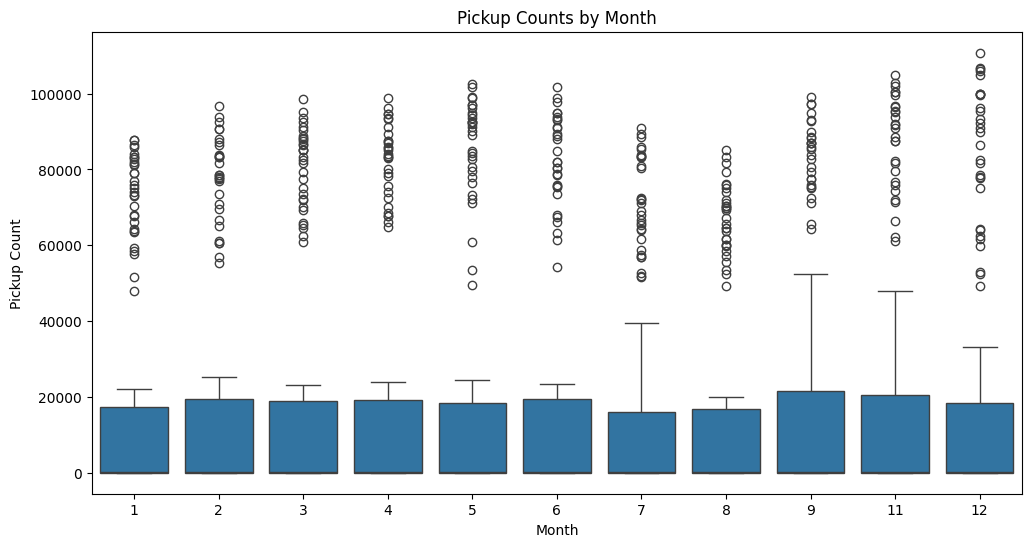

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='day_of_week', y='pickup_count', data=df_daily)
plt.title('Pickup Counts by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Pickup Count')
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='pickup_count', data=df_daily)
plt.title('Pickup Counts by Month')
plt.xlabel('Month')
plt.ylabel('Pickup Count')
plt.show()


In [22]:
# If 'cluster' is categorical, use one-hot encoding
df = pd.get_dummies(df_daily, columns=['cluster'], drop_first=True)

In [ ]:
# Features and target
X = df.drop(['pickup_date', 'pickup_count'], axis=1)
y = df['pickup_count']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


### Model Selection and Training

In [26]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [27]:
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [28]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           scoring='neg_mean_absolute_error')

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, X_test, y_test):
    # Generate predictions
    predictions = model.predict(X_test)
    
    # Compute metrics
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)  # RMSE is the square root of MSE
    r2 = r2_score(y_test, predictions)
    
    # Print the results
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")

# Evaluate Random Forest
print("Random Forest Performance:")
evaluate_model(rf, X_test, y_test)

# Evaluate Gradient Boosting
print("\nGradient Boosting Performance:")
evaluate_model(gb, X_test, y_test)

# Evaluate Best Random Forest from Grid Search
print("\nBest Random Forest Performance:")
evaluate_model(best_rf, X_test, y_test)


Random Forest Performance:
Mean Absolute Error (MAE): 34.9667
Mean Squared Error (MSE): 23639.4914
Root Mean Squared Error (RMSE): 153.7514
R2 Score: 0.1379

Gradient Boosting Performance:
Mean Absolute Error (MAE): 144.9242
Mean Squared Error (MSE): 52715.0787
Root Mean Squared Error (RMSE): 229.5976
R2 Score: -0.9225

Best Random Forest Performance:
Mean Absolute Error (MAE): 34.9668
Mean Squared Error (MSE): 23636.4075
Root Mean Squared Error (RMSE): 153.7414
R2 Score: 0.1380
